In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from os import path
import glob

from src.utils import *
from src.forward_model import *

### Load in data

In [2]:
comps_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/comps.npy'
weights_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/weights.npy'

# Ground truth record path
gt_path = path.join('/home/rshuai/research/u-net-reconstruction/data/datasets/for_model_16/ground_truths')
gt_files = glob.glob(path.join(gt_path, '*'))

# Simulation output record path
record_dir = path.join('/home/rshuai/research/u-net-reconstruction/data/datasets/for_model_16/train')

# Output name prefix
sample_names = 'sample'

obj_dims = (648, 486)

In [3]:
# Load in comps and weights
h = np.load(comps_path)
weights = np.load(weights_path)

In [4]:
print(h.shape)

(24, 1, 648, 486)


In [5]:
print(weights.shape)

(24, 1, 648, 486)


### Load in TFRecord data

In [6]:
# TFRecord Utils
feature_description = {
    'plane': tf.io.FixedLenFeature(obj_dims, tf.float32)
}
def _parse_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

def _create_example(plane, sim):
    plane_feature = tf.train.Feature(float_list=tf.train.FloatList(value=plane.ravel()))
    sim_feature = tf.train.Feature(float_list=tf.train.FloatList(value=sim.ravel()))
    feature = {
        'plane': plane_feature,
        'sim': sim_feature
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

### Why's this so slow?
# def ravel_tf(x):
#     return tf.reshape(x, tf.math.reduce_prod(tf.shape(x)))

# def _create_example_tf(plane, sim):
#     plane_feature = tf.train.Feature(float_list=tf.train.FloatList(value=ravel_tf(plane)))
#     sim_feature = tf.train.Feature(float_list=tf.train.FloatList(value=ravel_tf(sim)))
#     feature = {
#         'plane': plane_feature,
#         'sim': sim_feature
#     }
#     return tf.train.Example(features=tf.train.Features(feature=feature))


In [7]:
raw_dataset = tf.data.TFRecordDataset(filenames=gt_files)
dataset = raw_dataset.map(_parse_function)

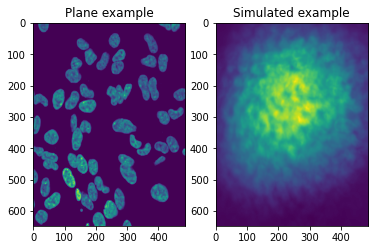

In [8]:
# Visualize a random example and its simulation under the forward model
dataset_iter = iter(dataset.shuffle(32))
plane_example = next(dataset_iter)['plane'].numpy()

model = ForwardModel()
sim_example = model.A_svd_2d(plane_example, weights, h)

fig = plt.figure()

ax1 = plt.subplot(121)
ax1.imshow(plane_example)
ax1.set_title("Plane example")

ax2 = plt.subplot(122)
ax2.imshow(sim_example)
ax2.set_title("Simulated example")

plt.show()

## Forward Model with Components

In [9]:
model = ForwardModel()

# Noise
rank=6
mu=0
sigma=np.random.rand(len(gt_files))*0.04+0.01 #abit much maybe 0.04 best
PEAK=np.random.rand(len(gt_files))*1000+50


for i, sample in enumerate(dataset):
    plane = sample['plane']
    sim = tf.dtypes.cast(model.A_svd_2d_tf_components(plane, weights, h), dtype=tf.float32)[:rank]
    
    # Noise Generation
    sim=sim/tf.math.reduce_max(sim)
    sim=tf.nn.relu(sim)

    p_noise = tf.squeeze(tf.random.poisson([1], sim * PEAK[i])) / PEAK[i]
    g_noise= tf.random.normal([rank, 648, 486], mu, sigma[i])
    sim=sim+g_noise+p_noise
    sim=sim/tf.math.reduce_max(sim)
    sim=tf.nn.relu(sim)
#     print(sim.shape)
    
#     # Wiener Deconvolution
    x = sim
#     x = model.wiener_deconvolve_one_step(sim, psf, K)
 
    
    # Write to file
    tf_example = _create_example(plane.numpy(), x.numpy())
    record_file = path.join(record_dir, sample_names + '-sim-%.5d.tfrecord' % i)
    
    with tf.io.TFRecordWriter(record_file) as writer:
        writer.write(tf_example.SerializeToString())

    if i % 500 == 0:
        print('sim-%.5d processed' % i)

sim-00000 processed
sim-00500 processed
sim-01000 processed
sim-01500 processed
sim-02000 processed
sim-02500 processed
sim-03000 processed
sim-03500 processed
sim-04000 processed
sim-04500 processed
sim-05000 processed
sim-05500 processed
